In [1]:
#!pip install wordcloud -q

In [2]:
#!pip install nltk

In [11]:
#!pip install arabica

In [36]:
#!pip install unidecode

In [65]:
import pandas as pd
import numpy as np
import os as os
import pickle
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.util import ngrams
import acessos as ac
from arabica import arabica_freq
from unidecode import unidecode
import re

In [205]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
query_count = """

select 
count(distinct msg.id_issue) as nr_chats
from cx_curated_zone.helpshift_issues_messages msg
where ds_entidade = 'cliente'
and dt_envio_mensagem >= to_date('2022-06-01','yyyy-mm-dd')
and lower(ds_message) <> 'screenshot sent'
and lower(ds_message) <> 'ok'
and lower(ds_message) <> 'outros assuntos'
and lower(ds_message) <> 'quero falar de outra coisa'
and lower(ds_message) <> 'nenhuma das opções'
and lower(ds_message) <> 'é outra coisa'
and lower(ds_message) <> 'nenhuma dessas'
and lower(ds_message) <> 'sim'
and lower(ds_message) <> 'não'
and lower(ds_message) <> 'nao'
and lower(ds_message) <> 'oi'
and lower(ds_message) <> '?'
and lower(ds_message) <> '??'
and lower(ds_message) <> 'bom dia'
and lower(ds_message) <> 'boa tarde'
and lower(ds_message) <> 'boa noite'

"""

count = ac.df_athena('flavia-costa', query_count)

In [6]:
def sampleSize(
    population_size,
    margin_error,
    confidence_level,
    sigma=1/2
):
    """
    Calculate the minimal sample size to use to achieve a certain
    margin of error and confidence level for a sample estimate
    of the population mean.
    Inputs
    -------
    population_size: integer
        Total size of the population that the sample is to be drawn from.
    margin_error: number
        Maximum expected difference between the true population parameter,
        such as the mean, and the sample estimate.
    confidence_level: number in the interval (0, 1)
        If we were to draw a large number of equal-size samples
        from the population, the true population parameter
        should lie within this percentage
        of the intervals (sample_parameter - e, sample_parameter + e)
        where e is the margin_error.
    sigma: number
        The standard deviation of the population.  For the case
        of estimating a parameter in the interval [0, 1], sigma=1/2
        should be sufficient.
    """
    alpha = 1 - (confidence_level)
    # dictionary of confidence levels and corresponding z-scores
    # computed via norm.ppf(1 - (alpha/2)), where norm is
    # a normal distribution object in scipy.stats.
    # Here, ppf is the percentile point function.
    zdict = {
        .90: 1.645,
        .91: 1.695,
        .99: 2.576,
        .97: 2.17,
        .94: 1.881,
        .93: 1.812,
        .95: 1.96,
        .98: 2.326,
        .96: 2.054,
        .92: 1.751
    }
    if confidence_level in zdict:
        z = zdict[confidence_level]
    else:
        from scipy.stats import norm
        z = norm.ppf(1 - (alpha/2))
    N = population_size
    M = margin_error
    numerator = z**2 * sigma**2 * (N / (N-1))
    denom = M**2 + ((z**2 * sigma**2)/(N-1))
    return numerator/denom

In [271]:
nr_amostra = round(sampleSize(population_size = count.iloc[0,0], margin_error = 0.005, confidence_level= 0.99), 0).astype('int')

In [272]:
nr_amostra

65153

In [274]:
query = """

select 
msg.id_issue
, msg.dt_envio_mensagem
, msg.ds_message
, novas_tags.hierarquia_4
, novas_tags.fila_de_atendimento
from cx_curated_zone.helpshift_issues_messages msg
left join "cx_curated_zone"."helpshift_issues" AS issues_macro ON msg."id_issue" = issues_macro."id_issue"
left join "cx_curated_zone"."helpshift_tag_niveis" AS helpshift_tag ON msg."id_issue" = helpshift_tag."id_issue"
left join processed_zone_api_cxm_tags.tags_hierarquia_gerencial as novas_tags ON trim(lower(n3)) = trim(lower(nm_tag_n3))
where ds_entidade = 'cliente'
and dt_envio_mensagem >= to_date('2022-06-01','yyyy-mm-dd')
and lower(ds_message) <> 'screenshot sent'
and lower(ds_message) <> 'ok'
and lower(ds_message) <> 'outros assuntos'
and lower(ds_message) <> 'quero falar de outra coisa'
and lower(ds_message) <> 'nenhuma das opções'
and lower(ds_message) <> 'é outra coisa'
and lower(ds_message) <> 'nenhuma dessas'
and lower(ds_message) <> 'sim'
and lower(ds_message) <> 'não'
and lower(ds_message) <> 'nao'
and lower(ds_message) <> 'oi'
and lower(ds_message) <> '?'
and lower(ds_message) <> '??'
and lower(ds_message) <> 'bom dia'
and lower(ds_message) <> 'boa tarde'
and lower(ds_message) <> 'boa noite'
and novas_tags.hierarquia_4 is not null
order by rand() desc

"""

query = query + "limit " + str(nr_amostra)


df = ac.df_athena('flavia-costa', query)

In [30]:
def replace_unuseful_messages(text):
    '''
    Replace automatic and irrelevant (for the project purpose) messages with empty string
    '''
    unuseful_messages = [
        'Outros assuntos',
        'Quero falar de outra coisa',
        'Quero resolver uma coisa',
        'Falar com atendente',
        '&Eacute; outra coisa',
        '&Eacute; outro assunto',
        'Voltar pro come&ccedil;o',
        '&Eacute; outro motivo',
        'Quero falar com atendente',
        'Me mostra as op&ccedil;&otilde;es de antes',
        'Quero falar de outro assunto',
        '&Eacute; outro assunto',
        '&Eacute; outra coisa ',
        'N&atilde;o, ainda tenho d&uacute;vidas',
        'Nenhuma das op&ccedil;&otilde;es',
        'Falar de outra coisa',
        'Quero voltar pro come&ccedil;o',
        'Voltar pro come&ccedil;o',
        'Falar com atendente',
        'Pode sim Por favor',
        'Não, ainda tenho dúvidas',
        'Certo',
        'Obrigado',
        'Responde'
    ]

    if text.strip() in unuseful_messages:
        return ''

    return text


In [275]:
def remove_emoji(text):
    '''
    Replace emojis with empty string
    '''
    regrex_pattern = re.compile(pattern="["
                                u"\U0001F600-\U0001F64F"  # emoticons
                                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                "]+", flags=re.UNICODE)
    return regrex_pattern.sub(r'', str(text))

In [276]:
def clean_text(x):
    x = x.strip()
    x = x.lower()
    x = unidecode(x)
    x = re.sub(r'\t', ' ', x)
    x = re.sub(r'http\S+', '', x)  # remove url
    x = re.sub(r'screenshot sent', 'screenshotsent', x)
    x = re.sub(r'will bank', 'willbank', x)
    x = re.sub(r'(nbsp\;|[rl]dquo\;|quot\;|acute\;|tilde\;|circ\;|grave\;|cedil\;|\&|\/)', '', x)  # replace special characters
    
    x = x.replace('&ccedil;','ç')
    x = x.replace('&atilde;;','ã')
    x = x.replace('&otilde;;','õ')
    x = re.sub(r'(\d{1,}|\!|\?|\,|\.|\\n|\:|\;|\`|\´|\-|\_)', ' ', x)  # replace punctuation and remove numbers
    x = x.replace('  ',' ')
    x = x.replace('\n','')
    x = x.strip()
    return x

In [277]:
def retira_saudacoes(text):
       
   regex_list = [
        'bo[ma] (dia|tarde|noite)',
        'agradeco', 'agradecido',
        '(tu?do?|esta|tah?) (b[eo]m|cert(inh)?[oa]|ok)',
        'ok', 'okay', 'sim',
        'oi{1,}e{0,}', 'ola', 'opa',
        'beleza', 'blz',
        'compreendi(do)?',
        'entendi(do)?',
        'tendi(do)?',
        '(muito|mt)? ?(obrigad[oa]|obg|b[oe]m)',
        'b?a{1,10}h?',
        'abracos?',
        '(por|de) na?da?',
        'por (favor|gentileza)'
    ]
   
   regex_list += stopwords
   pattern = r'\b(' + '|'.join(regex_list) + r')\b'
   text = re.sub(pattern, '', str(text))
   text = text.replace('  ',' ')
   return text

In [285]:
stopwords= ['não','nao',  'da', 'em', 'você', 'de', 'ao', 'os', 'que', 'e', 'eu', 'o', 'estou', 'ele','ela','pra', 'pro', 'entao', 'ta', 'to', 'ai', 'la', 'lo', 'lhe', 'ne']

In [286]:
df['ds_message_clean'] = df['ds_message'].apply(replace_unuseful_messages)
df['ds_message_clean'] = df['ds_message_clean'].apply(remove_emoji)
df['ds_message_clean'] = df['ds_message_clean'].apply(clean_text)
df['ds_message_clean'] = df['ds_message_clean'].apply(retira_saudacoes)

In [294]:
df_clean = df.query('ds_message_clean != " "').query('ds_message_clean != "  "').query('ds_message_clean != ""')

In [297]:
df_agg_tmp = arabica_freq(
            text = df_clean['ds_message_clean'],
            time = df_clean['dt_envio_mensagem'],
            time_freq = 'M',            # Calculates monthly n-gram frequencies
            max_words = 5,              # Displays only the first three most frequent unigrams, bigrams, and trigrams
            stopwords = ['portuguese'], # Removes English set of stopwords
            skip = [stopwords],         # Excludes string from n-gram calculation
            numbers = True,             # Removes numbers
            punct = True,               # Removes punctuation
            lower_case = True) 

In [298]:
df_agg_tmp.head(10)

,period,unigram,bigram,trigram
0,2022-06,"cartao: 1019,fatura: 587,ja: 544,limite: 521,q...","preciso,ajuda: 154,limite,credito: 136,quero,n...","ainda,preciso,ajuda: 117,quero,negociar,chat: ..."
1,2022-07,"cartao: 936,fatura: 539,quero: 503,limite: 479...","quero,negociar: 175,negociar,chat: 144,limite,...","quero,negociar,chat: 144,duvidas,sobre,negocia..."
2,2022-08,"cartao: 1004,fatura: 554,quero: 526,limite: 43...","quero,negociar: 162,negociar,chat: 130,limite,...","quero,negociar,chat: 130,duvidas,sobre,negocia..."
3,2022-09,"cartao: 1020,quero: 644,fatura: 624,limite: 43...","quero,negociar: 264,negociar,chat: 221,limite,...","quero,negociar,chat: 221,duvidas,sobre,negocia..."
4,2022-10,"cartao: 1030,fatura: 675,quero: 671,limite: 52...","quero,negociar: 265,negociar,chat: 180,ainda,d...","quero,negociar,chat: 180,duvidas,sobre,negocia..."
5,2022-11,"cartao: 1122,fatura: 790,quero: 609,limite: 47...","quero,negociar: 222,fatura,cartao: 166,ainda,d...","quero,negociar,chat: 132,quero,negociar,fatura..."
6,2022-12,"cartao: 1106,fatura: 686,quero: 512,compra: 44...","fatura,cartao: 148,ainda,duvidas: 144,quero,ne...","quero,negociar,chat: 94,quero,falar,atendiment..."
7,2023-01,"cartao: 38,ja: 24,fatura: 24,dia: 22,ainda: 17","fatura,cartao: 6,cartao,fisico: 5,limite,credi...","quero,negociar,chat: 5,duvidas,sobre,negociaca..."


In [299]:
def ranking_hierarquia(df_clean):
    
    df_agg_ungroup_final = pd.DataFrame([], columns=['unigram', 'unigram_freq',
                                                     'bigram','bigram_freq','trigram','trigram_freq', 'hierarquia'])
    
    for i in df_clean['hierarquia_4'].unique():
        try:
            df_clean_tmp = df_clean[df_clean['hierarquia_4'] == i ]
            #print("==========================================================")
            #print(str(i))
            df_agg_ungroup_tmp = arabica_freq(
                text = df_clean_tmp['ds_message_clean'],
                time = df_clean_tmp['dt_envio_mensagem'],
                time_freq = 'ungroup',           # opção ungroup
                max_words = 3,             
                stopwords = ['portuguese'],   
                skip = [stopwords],         
                numbers = True,            
                punct = True,              
                lower_case = True) 
            
            result_temp = pd.DataFrame({'unigram': df_agg_ungroup_tmp['unigram'], 'unigram_freq': df_agg_ungroup_tmp['unigram_freq'],
                                        'bigram': df_agg_ungroup_tmp['bigram'], 'bigram_freq': df_agg_ungroup_tmp['bigram_freq'],
                                        'trigram': df_agg_ungroup_tmp['trigram'], 'trigram_freq': df_agg_ungroup_tmp['trigram_freq']}, index=[0])
            
            result_temp['hierarquia'] = i
                    
            df_agg_ungroup_final = df_agg_ungroup_final.append(result_temp)

        except IndexError:
            pass
                
    return df_agg_ungroup_final
        #print(df_agg_ungroup_tmp)
        

In [300]:
df_hierarquia = ranking_hierarquia(df_clean)
df_hierarquia['unigram_freq'] = df_hierarquia['unigram_freq'].astype('int')
df_hierarquia['bigram_freq'] = df_hierarquia['bigram_freq'].astype('int')
df_hierarquia['trigram_freq'] = df_hierarquia['trigram_freq'].astype('int')
df_hierarquia['unigram_h'] = df_hierarquia['hierarquia'] + ' : ' + df_hierarquia['unigram']
df_hierarquia['bigram_h'] = df_hierarquia['hierarquia'] + ' : ' + df_hierarquia['bigram']
df_hierarquia['trigram_h'] = df_hierarquia['hierarquia'] + ' : ' + df_hierarquia['trigram']

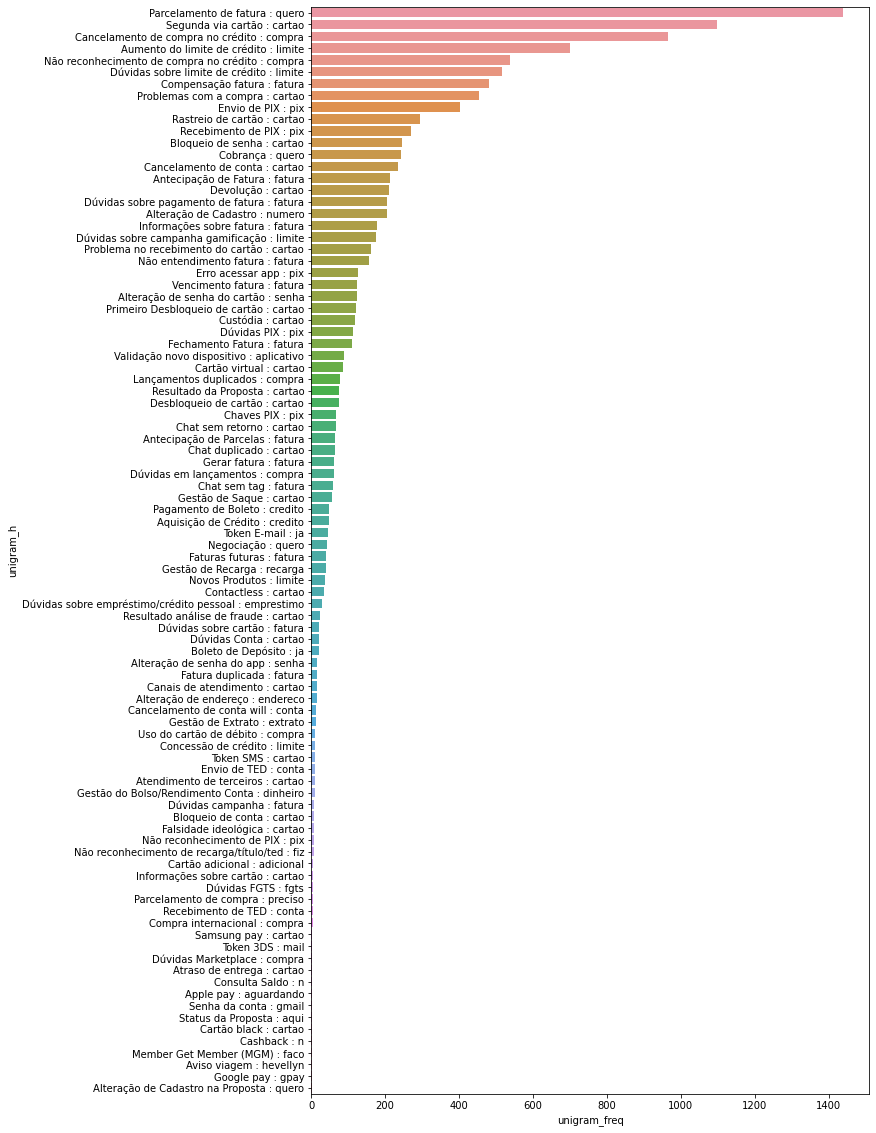

In [306]:
plt.figure(figsize=(10,20))
sns.barplot(data = df_hierarquia.sort_values(by ='unigram_freq', ascending=False), x = 'unigram_freq', y = 'unigram_h')
plt.show()

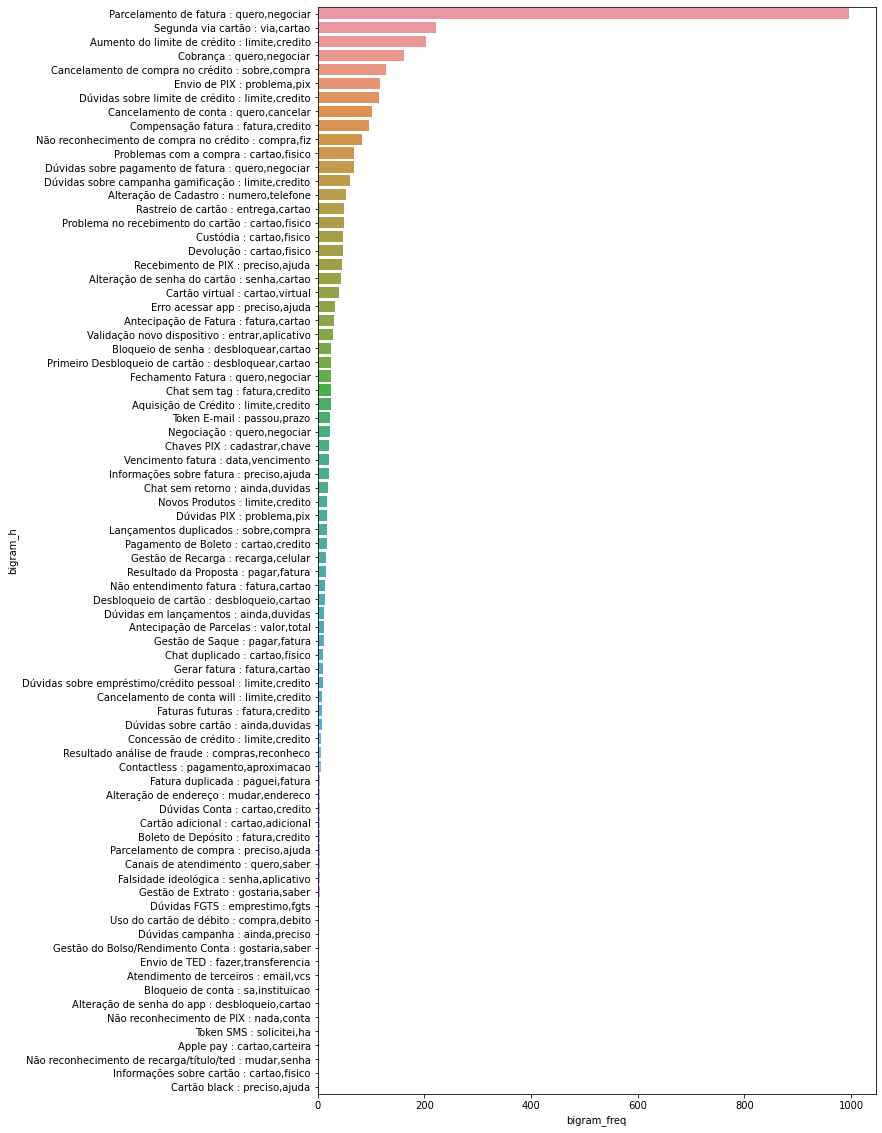

In [311]:
plt.figure(figsize=(10,20))
sns.barplot(data = df_hierarquia.query('bigram_freq > 1').sort_values(by ='bigram_freq', ascending=False), x = 'bigram_freq', y = 'bigram_h')
plt.show()

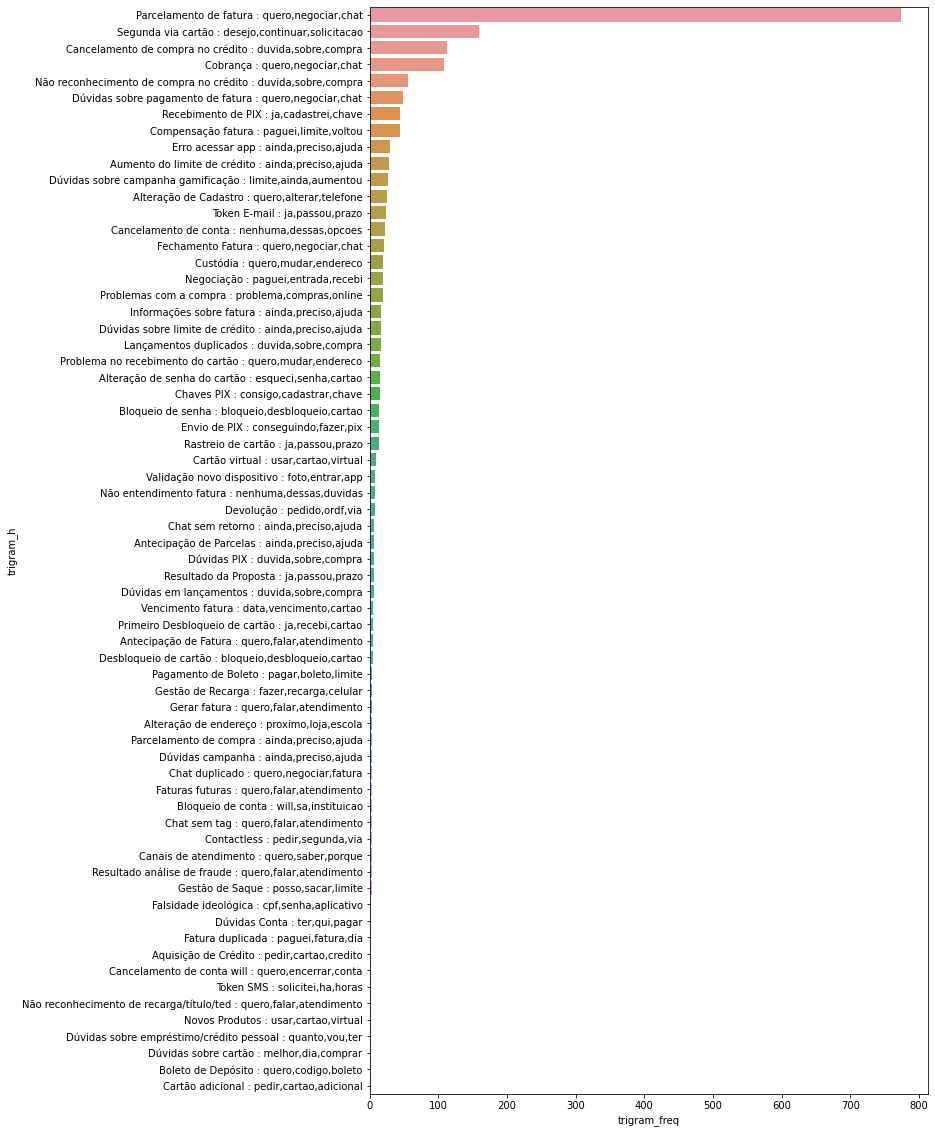

In [310]:
plt.figure(figsize=(10,20))
sns.barplot(data = df_hierarquia.query('trigram_freq > 1').sort_values(by ='trigram_freq', ascending=False), x = 'trigram_freq', y = 'trigram_h')
plt.show()

In [320]:
df_clean['mes'] = df_clean['dt_envio_mensagem'].astype(str).str[:7]

In [370]:
def ranking_hierarquia_tempo(df_clean):
    
    df_agg_ungroup_final = pd.DataFrame([], columns=['unigram', 'unigram_freq',
                                                     'bigram','bigram_freq','trigram','trigram_freq', 'hierarquia', 'mes'])
    
    for t in df_clean['mes'].unique():
        df_clean_tmp = df_clean[df_clean['mes'] == t ]
        
        for i in df_clean_tmp['hierarquia_4'].unique():
            try:
                df_clean_tmp = df_clean_tmp[df_clean_tmp['hierarquia_4'] == i ]

                df_agg_ungroup_tmp = arabica_freq(
                    text = df_clean_tmp['ds_message_clean'],
                    time = df_clean_tmp['dt_envio_mensagem'],
                    time_freq = 'ungroup',           # opção ungroup
                    max_words = 10,             
                    stopwords = ['portuguese'],   
                    skip = [stopwords],         
                    numbers = True,            
                    punct = True,              
                    lower_case = True) 
                
                result_temp = pd.DataFrame({'unigram': df_agg_ungroup_tmp['unigram'], 'unigram_freq': df_agg_ungroup_tmp['unigram_freq'],
                                            'bigram': df_agg_ungroup_tmp['bigram'], 'bigram_freq': df_agg_ungroup_tmp['bigram_freq'],
                                            'trigram': df_agg_ungroup_tmp['trigram'], 'trigram_freq': df_agg_ungroup_tmp['trigram_freq']}, index=[0])
                
                result_temp['hierarquia'] = i
                result_temp['mes'] = t
                        
                df_agg_ungroup_final = df_agg_ungroup_final.append(result_temp)

            except ValueError:
                pass
                
    return df_agg_ungroup_final
        

In [376]:
import nltk

In [380]:
trigram_freq = lambda s: list(nltk.FreqDist(nltk.trigrams(s.split(" "))).items())
out = df_clean['ds_message_clean'].apply(trigram_freq).explode()
out = pd.DataFrame(out.to_list(), index=out.index, columns=["trigram", "freq_trigrams"])

In [384]:
out.sort_values(by = 'freq_trigrams', ascending=False).head(50)

,trigram,freq_trigrams
58285,"(r$, , uber)",35.0
58285,"(uber, r$, )",35.0
58285,"(, uber, r$)",35.0
60450,"(zwj, zwj, zwj)",24.0
46372,"(, google, roblox)",24.0
46372,"(roblox, r$, )",17.0
46372,"(google, roblox, r$)",15.0
46372,"(r$, , google)",15.0
37821,"(, , )",12.0
11063,"(, , )",9.0


In [397]:
def ranking_hierarquia_tempo(df_clean):
    
    df_agg_ungroup_final = pd.DataFrame([], columns=['unigram', 'unigram_freq',
                                                     'bigram','bigram_freq','trigram','trigram_freq', 'hierarquia', 'mes'])
    
    for t in df_clean['mes'].unique():
        df_clean_tmp = df_clean[df_clean['mes'] == t ]
        
        for i in df_clean_tmp['hierarquia_4'].unique():
            try:
                df_clean_tmp = df_clean_tmp[df_clean_tmp['hierarquia_4'] == i ]

                df_agg_ungroup_tmp = arabica_freq(
                    text = df_clean_tmp['ds_message_clean'],
                    time = df_clean_tmp['dt_envio_mensagem'],
                    time_freq = 'ungroup',           # opção ungroup
                    max_words = 5,             
                    stopwords = ['portuguese'],   
                    skip = [stopwords],         
                    numbers = True,            
                    punct = True,              
                    lower_case = True) 
                
                result_temp = pd.DataFrame({'unigram': df_agg_ungroup_tmp['unigram'], 'unigram_freq': df_agg_ungroup_tmp['unigram_freq'],
                                            'bigram': df_agg_ungroup_tmp['bigram'], 'bigram_freq': df_agg_ungroup_tmp['bigram_freq'],
                                            'trigram': df_agg_ungroup_tmp['trigram'], 'trigram_freq': df_agg_ungroup_tmp['trigram_freq']}, index=[0])
                
                result_temp['hierarquia'] = i
                result_temp['mes'] = t
                        
                df_agg_ungroup_final = df_agg_ungroup_final.append(result_temp)

            except IndexError:
                pass
                
    return df_agg_ungroup_final

In [398]:
df_hierarquia_tmp = ranking_hierarquia_tempo(df_clean)
df_hierarquia_tmp['unigram_freq'] = df_hierarquia_tmp['unigram_freq'].astype('int')
df_hierarquia_tmp['bigram_freq'] = df_hierarquia_tmp['bigram_freq'].astype('int')
df_hierarquia_tmp['trigram_freq'] = df_hierarquia_tmp['trigram_freq'].astype('int')
df_hierarquia_tmp['unigram_h'] = df_hierarquia_tmp['mes'] + ' / ' + df_hierarquia_tmp['hierarquia'] + ' : ' + df_hierarquia_tmp['unigram']
df_hierarquia_tmp['bigram_h'] = df_hierarquia_tmp['mes'] + ' / ' + df_hierarquia_tmp['hierarquia'] + ' : ' + df_hierarquia_tmp['bigram']
df_hierarquia_tmp['trigram_h'] = df_hierarquia_tmp['mes'] + ' / ' + df_hierarquia_tmp['hierarquia'] + ' : ' + df_hierarquia_tmp['trigram']

ValueError: cannot call `vectorize` on size 0 inputs unless `otypes` is set

In [372]:
df_hierarquia_tmp.head(30)

,unigram,unigram_freq,bigram,bigram_freq,trigram,trigram_freq,hierarquia,mes,unigram_h,bigram_h,trigram_h
0,limite,78,"limite,credito",21,"ainda,preciso,ajuda",5,Aumento do limite de crédito,2022-12,2022-12 / Aumento do limite de crédito : limite,2022-12 / Aumento do limite de crédito : limit...,2022-12 / Aumento do limite de crédito : ainda...
0,compra,81,"ainda,duvidas",13,"duvida,sobre,compra",10,Não reconhecimento de compra no crédito,2022-11,2022-11 / Não reconhecimento de compra no créd...,2022-11 / Não reconhecimento de compra no créd...,2022-11 / Não reconhecimento de compra no créd...
0,gostaria,1,"gostaria,comprovante",1,"gostaria,comprovante,detalhado",1,Chat sem tag,2023-01,2023-01 / Chat sem tag : gostaria,"2023-01 / Chat sem tag : gostaria,comprovante","2023-01 / Chat sem tag : gostaria,comprovante,..."
0,compra,148,"fiz,compra",18,"duvida,sobre,compra",16,Cancelamento de compra no crédito,2022-09,2022-09 / Cancelamento de compra no crédito : ...,2022-09 / Cancelamento de compra no crédito : ...,2022-09 / Cancelamento de compra no crédito : ...
0,aplicativo,14,"entrar,aplicativo",3,"ja,ativei,localizacao",2,Validação novo dispositivo,2022-07,2022-07 / Validação novo dispositivo : aplicativo,"2022-07 / Validação novo dispositivo : entrar,...","2022-07 / Validação novo dispositivo : ja,ativ..."
0,ainda,8,"ainda,duvidas",5,"nenhuma,dessas,compras",1,Dúvidas em lançamentos,2022-10,2022-10 / Dúvidas em lançamentos : ainda,"2022-10 / Dúvidas em lançamentos : ainda,duvidas","2022-10 / Dúvidas em lançamentos : nenhuma,des..."
0,compra,85,"apareceu,compra",12,"apareceu,compra,fiz",9,Não reconhecimento de compra no crédito,2022-06,2022-06 / Não reconhecimento de compra no créd...,2022-06 / Não reconhecimento de compra no créd...,2022-06 / Não reconhecimento de compra no créd...
0,fatura,9,"preciso,ajuda",4,"ainda,preciso,ajuda",3,Chat sem retorno,2022-08,2022-08 / Chat sem retorno : fatura,"2022-08 / Chat sem retorno : preciso,ajuda","2022-08 / Chat sem retorno : ainda,preciso,ajuda"


In [373]:
df_hierarquia_tmp2 = df_hierarquia_tmp.groupby(['mes', 'trigram']).agg({'trigram_freq':['sum']})
df_hierarquia_tmp2.columns = df_hierarquia_tmp2.columns.droplevel(0)
df_hierarquia_tmp2 = df_hierarquia_tmp2.reset_index()

In [374]:
df_hierarquia_tmp2.head(20)

,mes,trigram,sum
0,2022-06,"apareceu,compra,fiz",9
1,2022-07,"ja,ativei,localizacao",2
2,2022-08,"ainda,preciso,ajuda",3
3,2022-09,"duvida,sobre,compra",16
4,2022-10,"nenhuma,dessas,compras",1
5,2022-11,"duvida,sobre,compra",10
6,2022-12,"ainda,preciso,ajuda",5
7,2023-01,"gostaria,comprovante,detalhado",1


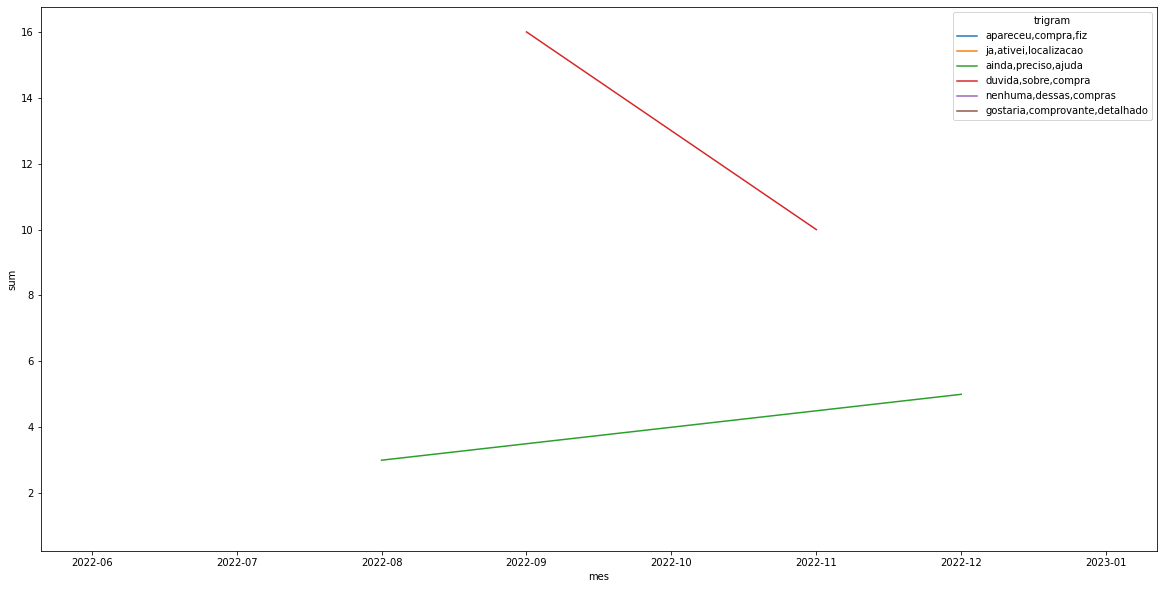

In [375]:
plt.figure(figsize = (20,10))
sns.lineplot(data=df_hierarquia_tmp2, x="mes", y="sum", hue = "trigram")
plt.show()

In [396]:
import nltk

ws_tok = nltk.tokenize.WhitespaceTokenizer()
token_list = ws_tok.tokenize(str(df_clean['ds_message_clean']))

#list(nltk.ngrams(token_list, 3))
nltk.FreqDist(ngrams(token_list, 3))


FreqDist({('0', 'quero', 'almenta'): 1, ('quero', 'almenta', 'meu'): 1, ('almenta', 'meu', 'limite'): 1, ('meu', 'limite', 'para'): 1, ('limite', 'para', 'fazer'): 1, ('para', 'fazer', 'pix'): 1, ('fazer', 'pix', 'mas'): 1, ('pix', 'mas', 'al...'): 1, ('mas', 'al...', '1'): 1, ('al...', '1', 'desde'): 1, ...})